# Introduction
Here we are trying to predict the overall stock market trend by sentiment analysis of 'top 25 news headlines' from 2008-08-11 to 2016-07-01.<br> We built various machine learning models on this data and tried to predict the trend.<br><br>
The datasets used for this projects are:
1. #### Reddit news data: 
   Historical news headlines from Reddit News Channel. They are ranked by the reddit user's votes.
2. #### Stock data: 
   Dow Jones Industrial Average (DJIA) is used as the stock market data.

Let's import some relevant packages.

In [38]:
# Load in the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### 1. Data transformation:
Load in our news data. The sentiment scores for the news is obtained using Stanford NLP Software. 

Here we are adding the sentiment scores of 5 consecutive days using 'rolling window'. This will be
the basis of next day stock trend.

In [39]:
# Load in setiment score's dataset
df = pd.read_csv("Sent_scores.csv", index_col=0)

# Add 5 consecutive day's scores
df["PosCount_cv"] = df["PosCount"].rolling(window=5).sum()
df["NegCount_cv"] = df["NegCount"].rolling(window=5).sum()
df["TrustCount_cv"] = df["TrustCount"].rolling(window=5).sum()
df["AngerCount_cv"] = df["AngerCount"].rolling(window=5).sum()
df["AnticipationCount_cv"] = df["AnticipationCount"].rolling(window=5).sum()
df["DisgustCount_cv"] = df["DisgustCount"].rolling(window=5).sum()
df["FearCount_cv"] = df["FearCount"].rolling(window=5).sum()
df["JoyCount_cv"] = df["JoyCount"].rolling(window=5).sum()
df["SadnessCount_cv"] = df["SadnessCount"].rolling(window=5).sum()
df["SurpriseCount_cv"] = df["SurpriseCount"].rolling(window=5).sum()
df.head(5)

,Date,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,...,PosCount_cv,NegCount_cv,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv
1,2008-06-08,19,28,12,15,9,5,22,3,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-06-09,25,25,20,16,16,3,22,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-06-10,11,27,12,16,12,9,21,6,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-06-11,19,19,15,11,6,9,15,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2008-06-12,17,24,15,15,8,10,20,6,12,...,91.0,123.0,74.0,73.0,51.0,36.0,100.0,31.0,49.0,18.0


In [30]:
# Load in stock market data
stock_df = pd.read_csv("DJIA_table.csv", index_col=1)
stock_df = stock_df.iloc[::-1]
stock_df.head(5)

,Date,High,Low,Close,Volume,Adj Close
Open,,,,,,
11432.089844,2008-08-08,11759.959961,11388.040039,11734.320312,212830000,11734.320312
11729.669922,2008-08-11,11867.110352,11675.530273,11782.349609,183190000,11782.349609
11781.700195,2008-08-12,11782.349609,11601.519531,11642.469727,173590000,11642.469727
11632.809570,2008-08-13,11633.780273,11453.339844,11532.959961,182550000,11532.959961
11532.070312,2008-08-14,11718.280273,11450.889648,11615.929688,159790000,11615.929688


Merge the two datasets and drop the irrelevant variables. Also, assign the binary class to each day stock trend. If today's stock price is larger than previous day's then assign class '1' otherwise assign class '0'.

In [40]:
# Mearge two datasets
df1 = pd.merge(df, stock_df)

# Drop irrelevant variabls
df2 = df1.drop('Volume', axis=1)
df2 = df2.drop('High', axis=1)
df2 = df2.drop('Low', axis=1)
df2 = df2.drop('Close', axis=1)
#df2 = df2.drop('Date', axis=1)
df2["trend"] = 0

# Assigning class to each day stock trend
for i in range(1,len(df2["Adj Close"])):
    if(df2["Adj Close"].iloc[i]>=df2["Adj Close"].iloc[i-1]):
        df2["trend"].iloc[i]=1
    else:
        df2["trend"].iloc[i]=0

df2 = df2.drop(df2.index[[0]])
df2.head(5)

,Date,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,Adj Close,trend
1,2008-08-11,12,15,7,8,7,3,15,5,6,...,51.0,48.0,33.0,20.0,87.0,19.0,37.0,22.0,11782.349609,1
2,2008-08-12,12,21,6,10,3,1,16,4,8,...,41.0,47.0,28.0,15.0,84.0,20.0,37.0,20.0,11642.469727,0
3,2008-08-13,21,19,19,12,5,2,16,6,8,...,52.0,45.0,26.0,9.0,78.0,24.0,36.0,19.0,11532.959961,0
4,2008-08-14,22,21,16,12,15,3,17,9,10,...,59.0,52.0,38.0,11.0,81.0,29.0,42.0,23.0,11615.929688,1
5,2008-08-15,15,23,14,14,4,3,20,8,8,...,62.0,56.0,34.0,12.0,84.0,32.0,40.0,22.0,11659.900391,1


In [41]:
df2 = df2.drop('Adj Close', axis=1)
df2["trend"].head(5)

1    1
2    0
3    0
4    1
5    1
Name: trend, dtype: int64

#### Train and Test split:
Split the 70% data as a training set and other 30% as a test set which will be used for predicting stock market trend.

In [42]:
# train-test split
train = df2.loc[0:1392,:]
test = df2.drop(train.index)

date_train = train["Date"]
date_test = test["Date"]

train = train.drop('Date', axis=1)
test = test.drop('Date',axis=1)

X = train.loc[:, train.columns!="trend"]
y = train.iloc[:,-1]

test_X = test.loc[:, test.columns!="trend"]
test_y = test.iloc[:,-1]

train.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,NegCount_cv,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend
1,12,15,7,8,7,3,15,5,6,5,...,99.0,51.0,48.0,33.0,20.0,87.0,19.0,37.0,22.0,1
2,12,21,6,10,3,1,16,4,8,3,...,95.0,41.0,47.0,28.0,15.0,84.0,20.0,37.0,20.0,0
3,21,19,19,12,5,2,16,6,8,3,...,89.0,52.0,45.0,26.0,9.0,78.0,24.0,36.0,19.0,0
4,22,21,16,12,15,3,17,9,10,8,...,96.0,59.0,52.0,38.0,11.0,81.0,29.0,42.0,23.0,1
5,15,23,14,14,4,3,20,8,8,3,...,99.0,62.0,56.0,34.0,12.0,84.0,32.0,40.0,22.0,1


### 2. Machine Learning models
Implementing some machine learning models including Random forest, KNN, Neural Networks, Naive Bayes, Decision tree, etc. using scikit-learn library to predict the stock trend.

### Random Forest

In [56]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
#clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10)
#clf = AdaBoostClassifier(n_estimators=100)
#clf = linear_model.LinearRegression()

clf.fit(X,y)
test["predict"] = clf.predict(test_X)
test.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend,predict
1393,30,35,27,20,9,10,31,6,17,9,...,99.0,82.0,46.0,44.0,125.0,27.0,70.0,29.0,0,0
1394,25,33,20,20,12,5,29,10,14,3,...,107.0,77.0,54.0,38.0,112.0,41.0,63.0,30.0,1,1
1395,23,25,23,13,12,5,11,10,10,7,...,109.0,76.0,57.0,36.0,98.0,42.0,59.0,30.0,0,1
1396,23,22,10,9,5,6,15,4,11,2,...,92.0,65.0,53.0,32.0,82.0,40.0,53.0,23.0,1,1
1397,27,22,19,13,11,3,18,8,9,4,...,85.0,68.0,47.0,27.0,88.0,36.0,52.0,19.0,1,1


Confusion matrix
[[ 20 258]
 [ 24 294]]


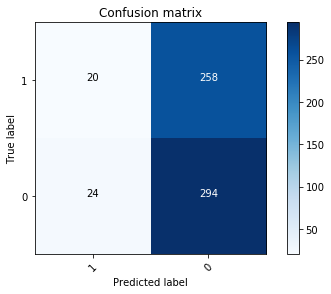

In [57]:
#confusion_matrix
cnf_matrix = confusion_matrix(test["trend"], test["predict"])
np.set_printoptions(precision=2)
class_names = ['1','0']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [58]:
print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

0.526845637584
[[ 20 258]
 [ 24 294]]
             precision    recall  f1-score   support

          0       0.45      0.07      0.12       278
          1       0.53      0.92      0.68       318

avg / total       0.50      0.53      0.42       596



## Feature Importance
As expected, importance of features - 'moving sum sentiment scores' is higher than daywise sentiment scores!

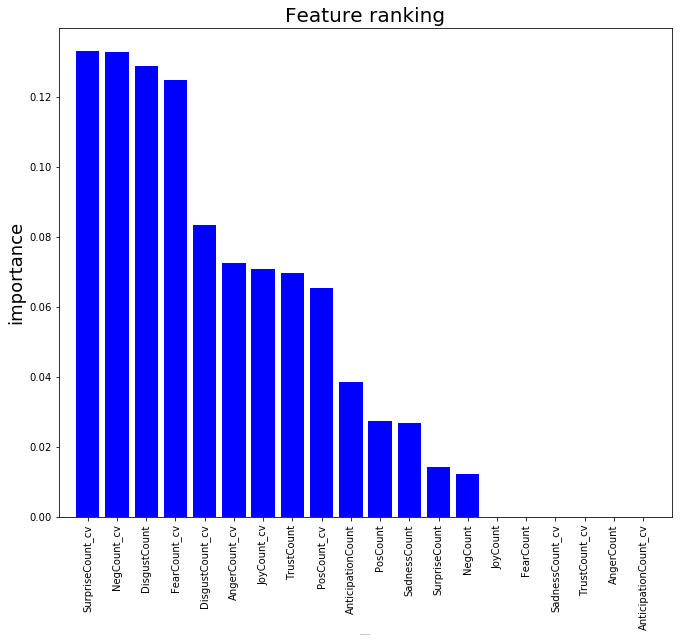

In [59]:
# feature_importancefrom sklearn import tree
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names= X.columns[indices]
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices],color="b", align="center")
plt.xticks(range(X.shape[1]), feature_names)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 0.05)
plt.xticks(rotation=90)
plt.show()

### Gradient Boosting Classifier

In [61]:
clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10)
#clf = AdaBoostClassifier(n_estimators=100)
#clf = linear_model.LinearRegression()

clf.fit(X,y)
test["predict"] = clf.predict(test_X)
test.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend,predict
1393,30,35,27,20,9,10,31,6,17,9,...,99.0,82.0,46.0,44.0,125.0,27.0,70.0,29.0,0,0
1394,25,33,20,20,12,5,29,10,14,3,...,107.0,77.0,54.0,38.0,112.0,41.0,63.0,30.0,1,1
1395,23,25,23,13,12,5,11,10,10,7,...,109.0,76.0,57.0,36.0,98.0,42.0,59.0,30.0,0,0
1396,23,22,10,9,5,6,15,4,11,2,...,92.0,65.0,53.0,32.0,82.0,40.0,53.0,23.0,1,1
1397,27,22,19,13,11,3,18,8,9,4,...,85.0,68.0,47.0,27.0,88.0,36.0,52.0,19.0,1,1


Confusion matrix
[[116 162]
 [113 205]]


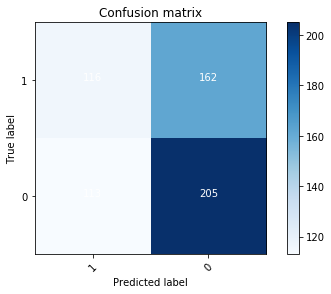

0.538590604027
[[116 162]
 [113 205]]
             precision    recall  f1-score   support

          0       0.51      0.42      0.46       278
          1       0.56      0.64      0.60       318

avg / total       0.53      0.54      0.53       596



In [62]:
#confusion_matrix
cnf_matrix = confusion_matrix(test["trend"], test["predict"])
np.set_printoptions(precision=2)
class_names = ['1','0']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

In [63]:
print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

0.538590604027
[[116 162]
 [113 205]]
             precision    recall  f1-score   support

          0       0.51      0.42      0.46       278
          1       0.56      0.64      0.60       318

avg / total       0.53      0.54      0.53       596



### AdaBoost Classifier

In [64]:
#clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10)
clf = AdaBoostClassifier(n_estimators=100)
#clf = linear_model.LinearRegression()

clf.fit(X,y)
test["predict"] = clf.predict(test_X)
test.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend,predict
1393,30,35,27,20,9,10,31,6,17,9,...,99.0,82.0,46.0,44.0,125.0,27.0,70.0,29.0,0,0
1394,25,33,20,20,12,5,29,10,14,3,...,107.0,77.0,54.0,38.0,112.0,41.0,63.0,30.0,1,1
1395,23,25,23,13,12,5,11,10,10,7,...,109.0,76.0,57.0,36.0,98.0,42.0,59.0,30.0,0,0
1396,23,22,10,9,5,6,15,4,11,2,...,92.0,65.0,53.0,32.0,82.0,40.0,53.0,23.0,1,1
1397,27,22,19,13,11,3,18,8,9,4,...,85.0,68.0,47.0,27.0,88.0,36.0,52.0,19.0,1,0


In [65]:
print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

0.468120805369
[[ 97 181]
 [136 182]]
             precision    recall  f1-score   support

          0       0.42      0.35      0.38       278
          1       0.50      0.57      0.53       318

avg / total       0.46      0.47      0.46       596



### Neural Network

In [82]:
#clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10)
#clf = AdaBoostClassifier(n_estimators=100)
#clf = linear_model.LinearRegression()
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,10), random_state=1)

clf.fit(X,y)
test["predict"] = clf.predict(test_X)
test.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend,predict
1393,30,35,27,20,9,10,31,6,17,9,...,99.0,82.0,46.0,44.0,125.0,27.0,70.0,29.0,0,0
1394,25,33,20,20,12,5,29,10,14,3,...,107.0,77.0,54.0,38.0,112.0,41.0,63.0,30.0,1,0
1395,23,25,23,13,12,5,11,10,10,7,...,109.0,76.0,57.0,36.0,98.0,42.0,59.0,30.0,0,1
1396,23,22,10,9,5,6,15,4,11,2,...,92.0,65.0,53.0,32.0,82.0,40.0,53.0,23.0,1,1
1397,27,22,19,13,11,3,18,8,9,4,...,85.0,68.0,47.0,27.0,88.0,36.0,52.0,19.0,1,1


In [83]:
print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

0.541946308725
[[ 38 240]
 [ 33 285]]
             precision    recall  f1-score   support

          0       0.54      0.14      0.22       278
          1       0.54      0.90      0.68       318

avg / total       0.54      0.54      0.46       596



### Naive Bayes

In [70]:
# Naive Bayes Algo
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, y)
test["predict"] = clf.predict(test_X)
test.head(5)

,PosCount,NegCount,TrustCount,AngerCount,AnticipationCount,DisgustCount,FearCount,JoyCount,SadnessCount,SurpriseCount,...,TrustCount_cv,AngerCount_cv,AnticipationCount_cv,DisgustCount_cv,FearCount_cv,JoyCount_cv,SadnessCount_cv,SurpriseCount_cv,trend,predict
1393,30,35,27,20,9,10,31,6,17,9,...,99.0,82.0,46.0,44.0,125.0,27.0,70.0,29.0,0,1
1394,25,33,20,20,12,5,29,10,14,3,...,107.0,77.0,54.0,38.0,112.0,41.0,63.0,30.0,1,1
1395,23,25,23,13,12,5,11,10,10,7,...,109.0,76.0,57.0,36.0,98.0,42.0,59.0,30.0,0,1
1396,23,22,10,9,5,6,15,4,11,2,...,92.0,65.0,53.0,32.0,82.0,40.0,53.0,23.0,1,1
1397,27,22,19,13,11,3,18,8,9,4,...,85.0,68.0,47.0,27.0,88.0,36.0,52.0,19.0,1,1


In [71]:
print(accuracy_score(test["trend"], test["predict"]))
print(confusion_matrix(test["trend"], test["predict"]))
print(classification_report(test["trend"], test["predict"]))

0.506711409396
[[ 78 200]
 [ 94 224]]
             precision    recall  f1-score   support

          0       0.45      0.28      0.35       278
          1       0.53      0.70      0.60       318

avg / total       0.49      0.51      0.48       596



### Conclusion:
The maximum accuracy of predicting overall stock market trend is 55%. It implies that sentiment of news headlines have the impact on stock market trend.